In [21]:
import re
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
nltk.download('punkt')

# Function to read and preprocess text
def read_and_preprocess(files):
    corpus = []
    for file in files:
        with open(file, 'r') as f:
            text = f.read().lower()
            # Remove punctuation
            text = re.sub(r'[^\w\s]', '', text)
            # Tokenize
            tokens = word_tokenize(text)
            corpus.extend(tokens)
    return corpus

# Specify the files for the seven books
files = ['HarryPotter/HP1.txt']
#, 'HarryPotter/HP3.txt', 'HarryPotter/HP4.txt', 'HarryPotter/HP5.txt', 'HarryPotter/HP6.txt', 'HarryPotter/HP7.txt']
# Preprocess the text
corpus = read_and_preprocess(files)


[nltk_data] Downloading package punkt to /home/zachs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
# Create vocabulary and mappings
unique_words = list(set(corpus))
word_to_idx = {word: i for i, word in enumerate(unique_words)}
idx_to_word = {i: word for i, word in enumerate(unique_words)}

# Label encoding for corpus
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(corpus)

# One-hot encoding for integer encoded corpus
onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [26]:
# Create training data
def generate_training_data(corpus, word_to_idx, window_size):
    X, y = [], []
    for i in range(len(corpus)):
        target_word = word_to_idx[corpus[i]]
        context_words = []
        for j in range(-window_size, window_size + 1):
            if j == 0 or i + j < 0 or i + j >= len(corpus):
                continue
            context_word = word_to_idx[corpus[i + j]]
            context_words.append(context_word)
        X.extend([target_word] * len(context_words))
        y.extend(context_words)
    return np.array(X), np.array(y)

window_size = 2
X, y = generate_training_data(corpus, word_to_idx, window_size)


In [27]:
# Parameters
vocab_size = len(unique_words)
embedding_dim = 100  # Dimension of the embedding vectors

# Define the model
input_layer = tf.keras.layers.Input(shape=(1,))
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, embeddings_regularizer = 'l1')(input_layer)
hidden_layer = tf.keras.layers.Dense(128, activation=None)(embedding_layer)
flatten_layer = tf.keras.layers.Flatten()(hidden_layer)
#dropout_layer = tf.keras.layers.Dropout(0.5)(hidden_layer)
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax')(flatten_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_test, y_test))

print("Model training completed.")


Epoch 1/50
5824/5824 [==============================] - 43s 7ms/step - loss: 10.5743 - accuracy: 0.0470 - val_loss: 10.3773 - val_accuracy: 0.0473
Epoch 2/50
5824/5824 [==============================] - 42s 7ms/step - loss: 10.4687 - accuracy: 0.0476 - val_loss: 10.6234 - val_accuracy: 0.0490
Epoch 3/50
5824/5824 [==============================] - 42s 7ms/step - loss: 10.6485 - accuracy: 0.0481 - val_loss: 10.7345 - val_accuracy: 0.0480
Epoch 4/50
5824/5824 [==============================] - 42s 7ms/step - loss: 10.7886 - accuracy: 0.0483 - val_loss: 10.8815 - val_accuracy: 0.0488
Epoch 5/50
5824/5824 [==============================] - 41s 7ms/step - loss: 10.8995 - accuracy: 0.0488 - val_loss: 11.0107 - val_accuracy: 0.0474
Epoch 6/50
5824/5824 [==============================] - 44s 8ms/step - loss: 10.9444 - accuracy: 0.0489 - val_loss: 11.1109 - val_accuracy: 0.0499
Epoch 7/50
5824/5824 [==============================] - 42s 7ms/step - loss: 10.9815 - accuracy: 0.0490 - val_loss: 11

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a model to extract embeddings
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
embeddings = embedding_model.get_weights()[0]  # Get the weights of the embedding layer

# Function to get embedding for a word
def get_embedding(word):
    word_idx = word_to_idx[word]
    return embeddings[word_idx]

# Compute similarity between the target word and all other words
def get_most_similar_words(target_word, top_n=10):
    target_embedding = get_embedding(target_word)
    similarities = []
    
    for idx, word in idx_to_word.items():
        if word == target_word:
            continue
        word_embedding = embeddings[idx]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities.append((word, similarity))
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
target_word = "harry"
top_related_words = get_most_similar_words(target_word, top_n=10)

print(f"Top related words to '{target_word}':")
for word, similarity in top_related_words:
    print(f"{word}: {similarity:.4f}")


Top related words to 'harry':
starts: 0.3725
wideawake: 0.3595
closely: 0.3485
pence: 0.3402
roughly: 0.3367
crockford: 0.3302
oy: 0.3249
wildly: 0.3197
definitely: 0.3060
urgently: 0.3041


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a model to extract embeddings
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
embeddings = embedding_model.get_weights()[0]  # Get the weights of the embedding layer

# Function to get embedding for a word
def get_embedding(word):
    word_idx = word_to_idx[word]
    return embeddings[word_idx]

# Compute similarity between the target word and all other words
def get_most_similar_words(target_word, top_n=10):
    target_embedding = get_embedding(target_word)
    similarities = []
    
    for idx, word in idx_to_word.items():
        if word == target_word:
            continue
        word_embedding = embeddings[idx]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities.append((word, similarity))
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
target_word = "harry"
top_related_words = get_most_similar_words(target_word, top_n=20)

print(f"Top related words to '{target_word}':")
for word, similarity in top_related_words:
    print(f"{word}: {similarity:.4f}")


Top related words to 'harry':
starts: 0.3725
wideawake: 0.3595
closely: 0.3485
pence: 0.3402
roughly: 0.3367
crockford: 0.3302
oy: 0.3249
wildly: 0.3197
definitely: 0.3060
urgently: 0.3041
seamus: 0.2950
desperately: 0.2944
oddly: 0.2859
helplessly: 0.2839
scurrying: 0.2815
restless: 0.2812
overshadowed: 0.2755
neatly: 0.2736
afterward: 0.2704
sweating: 0.2686


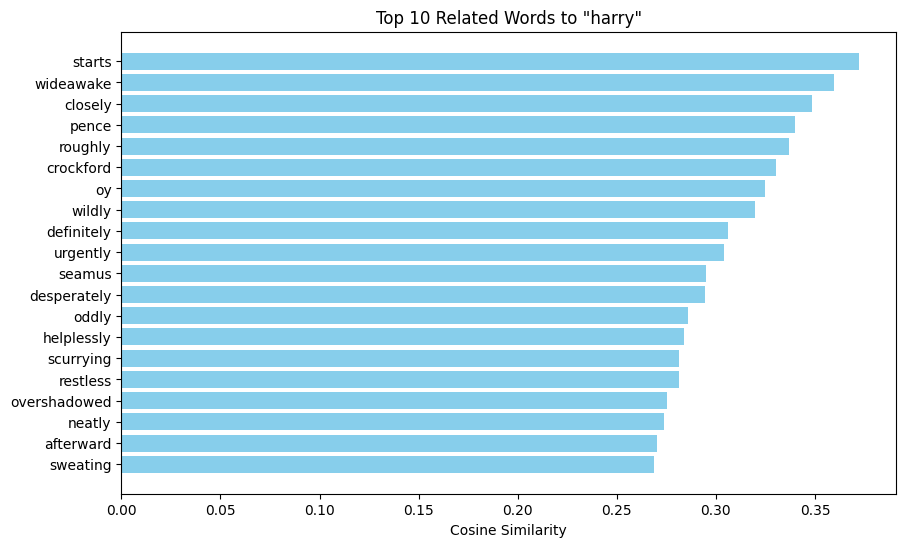

In [ ]:
import matplotlib.pyplot as plt

# Plotting the results
words, similarities = zip(*top_related_words)

plt.figure(figsize=(10, 6))
plt.barh(words, similarities, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.title(f'Top 10 Related Words to "{target_word}"')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity on top
plt.show()


In [ ]:
# Prepare data for t-SNE
words = [target_word] + [word for word, _ in top_related_words]
word_embeddings = np.array([get_embedding(word) for word in words])

# Apply t-SNE with adjusted perplexity
perplexity = min(30, len(words) - 1)  # Perplexity should be less than the number of samples
tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)

# Plot the t-SNE visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(words):
    ax.scatter(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2])
    ax.text(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2], word, fontsize=12)

ax.set_title('3D t-SNE visualization of word embeddings')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.set_zlabel('t-SNE dimension 3')
plt.show()

NameError: name 'TSNE' is not defined

## Increase window size

In [ ]:
# Create training data
def generate_training_data(corpus, word_to_idx, window_size):
    X, y = [], []
    for i in range(len(corpus)):
        target_word = word_to_idx[corpus[i]]
        context_words = []
        for j in range(-window_size, window_size + 1):
            if j == 0 or i + j < 0 or i + j >= len(corpus):
                continue
            context_word = word_to_idx[corpus[i + j]]
            context_words.append(context_word)
        X.extend([target_word] * len(context_words))
        y.extend(context_words)
    return np.array(X), np.array(y)

window_size = 5
X, y = generate_training_data(corpus, word_to_idx, window_size)


In [ ]:
# Parameters
vocab_size = len(unique_words)
embedding_dim = 100  # Dimension of the embedding vectors

# Define the model
input_layer = tf.keras.layers.Input(shape=(1,))
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1)(input_layer)
flatten_layer = tf.keras.layers.Flatten()(embedding_layer)
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax')(flatten_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_test, y_test))

print("Model training completed.")


/Users/manisha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
245458/245458 ━━━━━━━━━━━━━━━━━━━━ 2626s 11ms/step - loss: 6.9183 - val_loss: 6.8295
Epoch 2/50
245454/245458 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7729

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a model to extract embeddings
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=1).output)
embeddings = embedding_model.get_weights()[0]  # Get the weights of the embedding layer

# Function to get embedding for a word
def get_embedding(word):
    word_idx = word_to_idx[word]
    return embeddings[word_idx]

# Compute similarity between the target word and all other words
def get_most_similar_words(target_word, top_n=10):
    target_embedding = get_embedding(target_word)
    similarities = []
    
    for idx, word in idx_to_word.items():
        if word == target_word:
            continue
        word_embedding = embeddings[idx]
        similarity = cosine_similarity([target_embedding], [word_embedding])[0][0]
        similarities.append((word, similarity))
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
target_word = "harry"
top_related_words = get_most_similar_words(target_word, top_n=10)

print(f"Top related words to '{target_word}':")
for word, similarity in top_related_words:
    print(f"{word}: {similarity:.4f}")


In [ ]:
import matplotlib.pyplot as plt

# Plotting the results
words, similarities = zip(*top_related_words)

plt.figure(figsize=(10, 6))
plt.barh(words, similarities, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.title(f'Top 10 Related Words to "{target_word}"')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest similarity on top
plt.show()


# Prepare data for t-SNE
words = [target_word] + [word for word, _ in top_related_words]
word_embeddings = np.array([get_embedding(word) for word in words])

# Apply t-SNE with adjusted perplexity
perplexity = min(30, len(words) - 1)  # Perplexity should be less than the number of samples
tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)

# Plot the t-SNE visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(words):
    ax.scatter(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2])
    ax.text(word_embeddings_3d[i, 0], word_embeddings_3d[i, 1], word_embeddings_3d[i, 2], word, fontsize=12)

ax.set_title('3D t-SNE visualization of word embeddings')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.set_zlabel('t-SNE dimension 3')
plt.show()